In [1]:
using Pkg 
Pkg.activate("..");

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer, ReactiveMP, Distributions
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets , LaTeXStrings, StatsFuns 
using Optim, ForwardDiff
using KernelFunctions, MAT,LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, kernelmatrix 

import StatsFuns: normcdf, normccdf, normlogcdf, normlogccdf, normlogpdf, normpdf, logsumexp

In [3]:
include("../helper_functions/gp_helperfunction.jl")
include("../GPnode/UniSGPnode.jl")
include("../helper_functions/derivative_helper.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

In [4]:
Random.seed!(145)
xmin, xmax = -5, 5  # Bounds of the data
N          = 100 # Number of samples
xtrain     = sort(rand(Uniform(xmin, xmax), N))
xtest      = collect(range(xmin, xmax; length=400))
kernelfunc =  2*with_lengthscale(SEKernel(),1.2)
meanfunc   = (x) -> 0.0;
grammatrix = kernelmatrix(kernelfunc,xtrain,xtrain) + 1e-6*diageye(N)
ytrain     = rand(MvNormal(zeros(N),grammatrix))
p          = normcdf.(ytrain)
ytrainbin  = map(rand,Bernoulli.(p));
ytrainbin = float(ytrainbin);

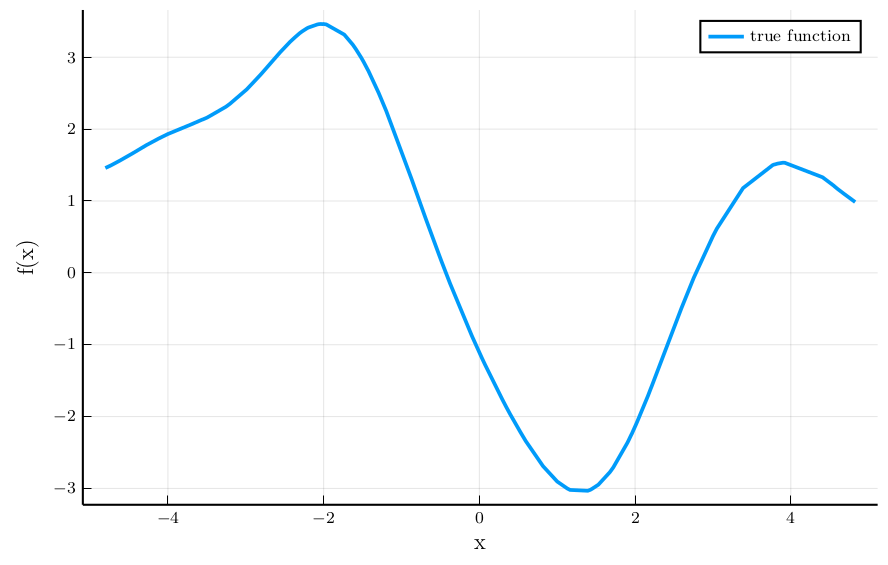

In [5]:
plot(xtrain,ytrain,label="true function",lw=1.8, legend=:topright)
xlabel!("x")
ylabel!("f(x)")

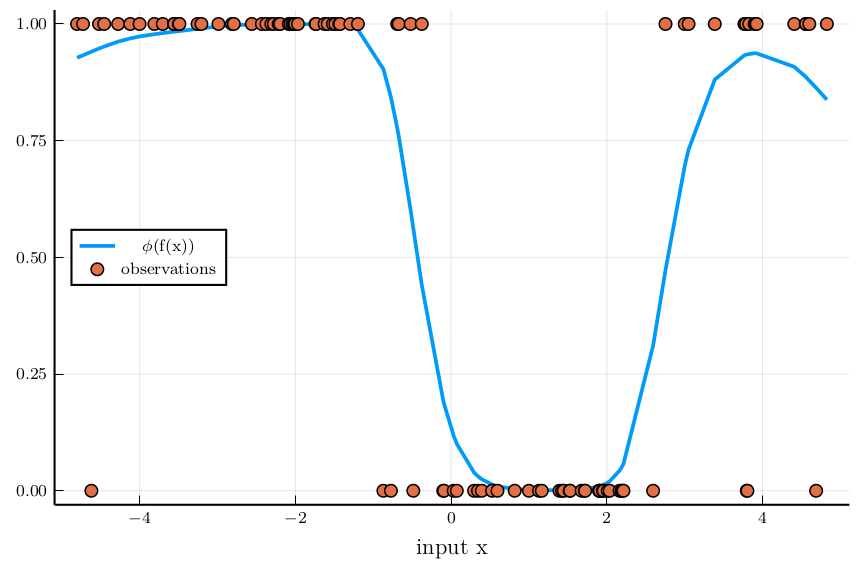

In [6]:
plot(xtrain,p,linewidth=1.8, label="ϕ(f(x))")
scatter!(xtrain,ytrainbin,legend=:left,label="observations")
xlabel!("input x")

In [7]:
M = 15; #number of inducing points 
Xu = range(-5.,5.;length=M);
mean_gp = (x) -> 0
kernel_gp(θ) = StatsFuns.softplus(θ[1]) * with_lengthscale(SEKernel(),StatsFuns.softplus(θ[2]))

θ_init = StatsFuns.invsoftplus.([1.,1.])

Ψ0 = [1.0;;]
Ψ1_trans = kernelmatrix(kernel_gp(θ_init),Xu,[xtrain[1]])
Ψ2 = kernelmatrix(kernel_gp(θ_init),Xu,[xtrain[1]]) * kernelmatrix(kernel_gp(θ_init),[xtrain[1]],Xu);
;

In [8]:
@model function gp_classification(y,x,θ)
    v ~ MvNormalMeanCovariance(zeros(M), 50diageye(M))
    w ~ GammaShapeRate(0.01,0.01)
    for i in eachindex(y)
        f[i] ~ UniSGP(x[i],v,w,θ) 
        y[i] ~ Probit(f[i])
    end
end

gp_constraints = @constraints begin
    q(f,v,w) = q(f)q(v)q(w)
end

@meta function meta_gp_classification(Xu,Ψ0,Ψ1_trans,Ψ2,KuuL,kernel,Lu)
    UniSGP() -> UniSGPMeta(nothing,Xu,Ψ0,Ψ1_trans,Ψ2,KuuL,kernel,Lu,0,N)
    Probit() -> ProbitMeta(32)
end

μ_v_init = zeros(M)
Σ_v_init = 50diageye(M)
gp_initialization = @initialization begin
    q(v) = MvNormalMeanCovariance(μ_v_init, Σ_v_init)
    q(w) = GammaShapeRate(1e-2,1e-2)
end
Rv_init = μ_v_init * μ_v_init' + Σ_v_init
Lu = cholesky(Rv_init).U;
;

## Do inference

In [9]:
function my_free_energy(θ)
    Kuu = kernelmatrix(kernel_gp(θ), Xu)
    KuuL = fastcholesky(Kuu).L
    infer_result = infer(
        model = gp_classification(θ = θ),
        iterations = 30,
        data = (y = ytrainbin, x = xtrain,),
        initialization = gp_initialization,
        constraints = gp_constraints,
        returnvars = (v = KeepLast(),w = KeepLast(),f = KeepLast(),),
        meta = meta_gp_classification(Xu,Ψ0,Ψ1_trans,Ψ2,KuuL,kernel_gp,Lu),
        free_energy = true,
    )
    return (infer_result.free_energy[end],infer_result.posteriors[:v], infer_result.posteriors[:w],infer_result.posteriors[:f])
end

function PerformInference(θ; epochs)
    FE_value = []
    q_v = []
    q_w = []
    θ_optimal = copy(θ)
    @inbounds for epoch=1:epochs
            #step 1: Perform inference for v, w 
            fe, qv,qw, qf = my_free_energy(θ_optimal)
            #step 2: optimize the hyperparameters 
            μ_v, Σ_v = mean_cov(qv)
            Rv = Σ_v + μ_v * μ_v' |> (x) -> fastcholesky!(x).U
            w = mean(qw)
            f = mean.(qf)

            negllh = (θ) -> neg_log_backwardmess_fast(θ;y_data=f, x_data=xtrain,v = μ_v,Uv=Rv, w=w,kernel=kernel_gp,Xu=Xu)
            grad! = (G, θ) -> grad_llh_new_default!(G, θ ;y_data=f, x_data=xtrain,v = μ_v,Uv=Rv, w=w,kernel=kernel_gp,Xu=Xu)
            res = optimize(negllh, grad!, θ_optimal, LBFGS())
            append!(FE_value,fe)
            push!(q_v, qv)
            push!(q_w,qw)
            θ_optimal = res.minimizer
    end
    return q_v, q_w, FE_value, θ_optimal
end

PerformInference (generic function with 1 method)

In [10]:
qv,qw, FE_value, θ_optimal = PerformInference(θ_init;epochs=500);

In [11]:
println("Optimal hyperparameters: ", StatsFuns.softplus.(θ_optimal))

Optimal hyperparameters: [0.28307103179255905, 1.3847608644015856]


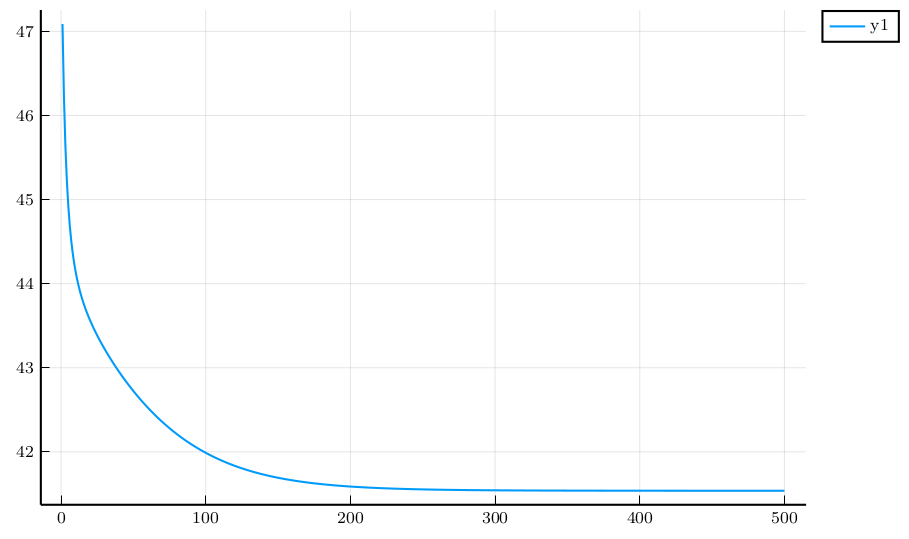

In [12]:
plot(FE_value)

In [13]:
function predict_new(x_test,qv,qw, qθ, meta)
    prediction_f = @call_rule UniSGP(:out, Marginalisation) (q_in=PointMass(x_test),q_v = qv, q_w = qw,q_θ = qθ, meta=meta)
    prediction_y = @call_rule Probit(:out, Marginalisation) (m_in=prediction_f,meta=ProbitMeta(32))
    return prediction_f, prediction_y
end

predict_new (generic function with 1 method)

In [14]:
predict_mean =[]
predict_var =[]
predict_func=[]
predict_var_func=[]
Kuu = kernelmatrix(kernel_gp(θ_optimal), Xu) + 1e-8 * I
KuuL = fastcholesky!(Kuu).L
for i=1:length(xtest)
    prediction_f, prediction_y = predict_new(xtest[i],qv[end],qw[end],PointMass(θ_optimal), UniSGPMeta(nothing,Xu,Ψ0,Ψ1_trans,Ψ2,KuuL,kernel_gp,Lu,0,N))
    append!(predict_func,mean(prediction_f))
    append!(predict_var_func,var(prediction_f)) 
    append!(predict_mean,mean(prediction_y))
    append!(predict_var,var(prediction_y)) 
end

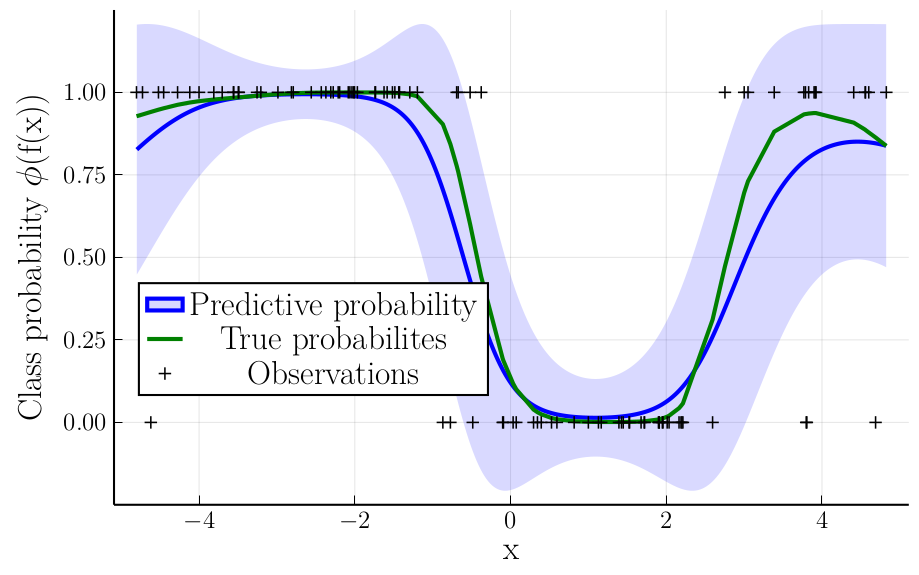

In [15]:
plot(xtest[9:393],predict_mean[9:393],ribbon = sqrt.(predict_var[9:393]),
    lw=2,label="Predictive probability",color=:blue,tickfontsize=12,legendfontsize=16, guidefontsize=16,
    fillalpha=0.15, fontfamily="monospace")
plot!(xtrain,p,linewidth=2,label="True probabilites",legend_position=(0.03,0.45),color=:green)
scatter!(xtrain,ytrainbin,label="Observations",marker=:cross, ms=4)
xlabel!("x")
ylabel!("Class probability ϕ(f(x))")

In [16]:
savefig("../texfiles/classification_ProbabilityResult.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/classification_ProbabilityResult.svg"

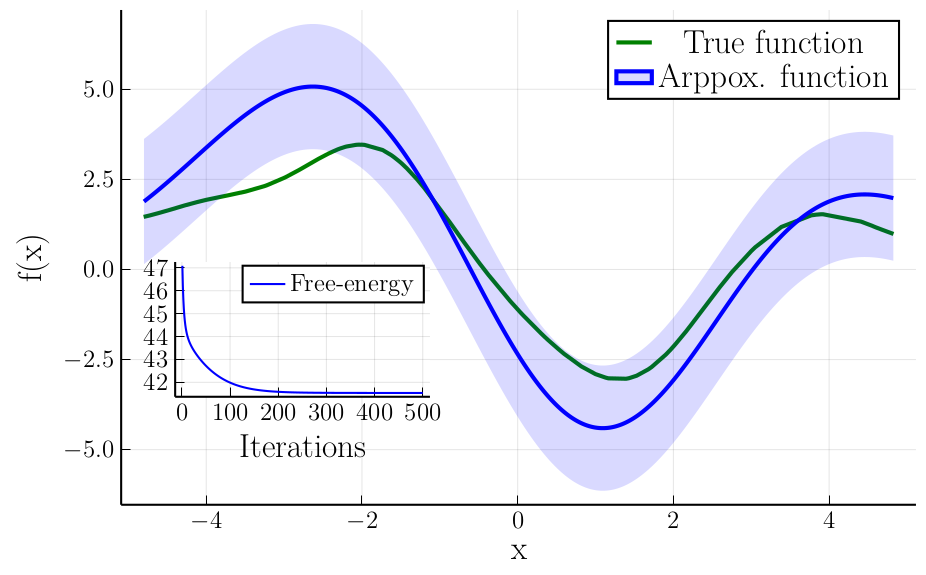

In [17]:
plot(xtrain,ytrain,label="True function",lw=2,color=:green)
plot!(xtest[9:393],predict_func[9:393],ribbon = sqrt.(predict_var_func[9:393]),
     label="Arppox. function",lw=2, legend=:topright, color=:blue,
     fillalpha=0.15, fontfamily="monospace",legendfontsize=16,tickfontsize=12,guidefontsize=16)
xlabel!("x")
ylabel!("f(x)")
plot!(FE_value,label="Free-energy", legend=:topright, 
        xlabel="Iterations",
        color=:blue,
        inset = (1, bbox(0.06, 0.18, 0.4, 0.4, :bottom, :left)),
        subplot = 2,
        legendfontsize=12,tickfontsize=12,guidefontsize=16)

In [48]:
savefig("../texfiles/classification_FunctionResult.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/classification_FunctionResult.svg"

In [18]:
Random.seed!(11)
#test data 
function predictgp(x_test,xdata,ydata,kernel)
    Ktrain = kernelmatrix(kernel,xdata,xdata) + 1e-6*I
    k_cross = kernelmatrix(kernel,x_test,xdata)

    mean_f = k_cross * inv(Ktrain) * ydata 
end
ytest = predictgp(xtest,xtrain,ytrain,kernelfunc)
p_test          = normcdf.(ytest)
ytestbin  = map(rand,Bernoulli.(p_test));
ytestbin = float(ytestbin);

In [19]:
#GP prediction
predictbin = zeros(length(predict_mean))
for i=1:length(predict_mean)
    predict_mean[i] > 0.5 ? predictbin[i] = 1.0 : predictbin[i] = 0.0
end

In [20]:
println("Number of error:", num_error(ytestbin, predictbin))
println("Error rate: ", error_rate(ytestbin, predictbin))

Number of error:35.0
Error rate: 0.0875


In [32]:
## save data 
using JLD 
save("../savefiles/xtrain_toyclassification.jld","xtrain",xtrain)
save("../savefiles/ytrain_toyclassification.jld","ytrain",ytrainbin)
save("../savefiles/xtest_toyclassification.jld","xtest",xtest)
save("../savefiles/ytest_toyclassification.jld","ytest",ytestbin)
save("../savefiles/Xu_toyclassification.jld","Xu",Xu)

In [ ]:
# Kuu = kernelmatrix(kernel_gp(θ_optimal), Xu)
#     KuuL = fastcholesky(Kuu).L
#     infer_result = infer(
#         model = gp_classification(θ = θ_optimal),
#         iterations = 100,
#         data = (y = ytrainbin, x = xtrain,),
#         initialization = gp_initialization,
#         constraints = gp_constraints,
#         returnvars = (v = KeepLast(),w = KeepLast(),f = KeepLast(),),
#         meta = meta_gp_classification(Xu,Ψ0,Ψ1_trans,Ψ2,KuuL,kernel_gp,Lu),
#         free_energy = true,
#     )
# qv = infer_result.posteriors[:v]
# qw = infer_result.posteriors[:w]